Environment Setup

Assuming you have installed Python on your system, and you can install new packages using `pip` command, this immediate cell below will read the setup to run project.

In [1]:
!pip3 install -r requirements.txt
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

In [2]:
import os
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from textblob import TextBlob, Word

from sklearn.feature_extraction.text import CountVectorizer # Bag of words library
from sklearn.feature_extraction.text import TfidfTransformer # Convert bag of words into tf-idf matrix
from sklearn.feature_selection import SelectKBest, chi2 # import kernel library
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline # create a pipeline to fit data

from sklearn.svm import LinearSVC # SVM Model library
from sklearn.naive_bayes import GaussianNB, MultinomialNB # NaiveBayes
from sklearn.ensemble import RandomForestClassifier # RandomForest

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## Data

In [3]:
"""
Two dataset are available, info can be found at 
1. data/imdb-movie-reviews/data_metadata.txt
2. data/restaurant-reviews/data_metadata.txt
choose one of these dataset to run experiment
"""
dataset_name = "RestaurantReviewsData"
# dataset_name = "IMDBReviewsData"


class DatasetIMDB:
    def __init__(self,):
        self.train: pd.DataFrame = pd.read_csv(os.path.join("data", "imdb-movie-reviews", "Train.csv"))
        self.test: pd.DataFrame = pd.read_csv(os.path.join("data", "imdb-movie-reviews", "Test.csv"))
        # self.valid: pd.DataFrame = pd.read_csv(os.path.join("data", "imdb-movie-reviews", "Valid.csv"))

        self.data = pd.concat([self.train, self.test], axis=0)

        # if not (self.train.columns.tolist() == self.test.columns.tolist() == self.valid.columns.tolist()):
        if not (self.train.columns.tolist() == self.test.columns.tolist()):
            raise ValueError(f"Name of columns are not consistent in {str(list(vars(self).keys()))} variable")
        else:
            print("IMDB movies reviews dataset loaded successfully")
            # print(f"Train: {self.train.shape}\nTest: {self.test.shape}\nValid: {self.valid.shape}")
            print(f"Train: {self.train.shape}\nTest: {self.test.shape}")
            print(f"Class Distribution\n{self.data['label'].value_counts()}")


class DatasetRestaurantReviews:
    def __init__(self, test_size: float = 0.2, valid_size: float = 0.15):
        self.data: pd.DataFrame = pd.read_csv(os.path.join("data", "restaurant-reviews", "Restaurant_Reviews.tsv"), delimiter="\t")
        self.data.columns = ["text", "label"]
        self.split_dataset(test_size, valid_size)

    def split_dataset(self, test_size: float, valid_size: float):
        self.train, self.test = train_test_split(self.data, test_size=test_size, stratify=self.data.label)
        # self.train, self.valid = train_test_split(self.train, test_size=valid_size, stratify=self.train.label)
        print("Restaurant reviews dataset loaded successfully")
        # print(f"Train: {self.train.shape}\nTest: {self.test.shape}\nValid: {self.valid.shape}")
        print(f"Train: {self.train.shape}\nTest: {self.test.shape}")
        print(f"Class Distribution\n{self.data['label'].value_counts()}")


if dataset_name.__eq__("IMDBReviewsData"):
    data = DatasetIMDB()
elif dataset_name.__eq__("RestaurantReviewsData"):
    data = DatasetRestaurantReviews()
else:
    raise ValueError("dataset_name must be one of IMDB or Restaurant")


Restaurant reviews dataset loaded successfully
Train: (800, 2)
Test: (200, 2)
Class Distribution
label
1    500
0    500
Name: count, dtype: int64


In [4]:
def data_preprocessing(data):
    """
    method do some preprocessing as per suggested in description document
    """
    text_column_name = "text"
    # 1. convert to lower case
    data[text_column_name] = data[text_column_name].apply(lambda x: " ".join(x.lower() for x in x.split()))
    # 2. cleaning 
    stopWords = stopwords.words("english")
    data[text_column_name] = data[text_column_name].apply(lambda x: " ".join(x for x in x.split() if x not in stopWords)) # remove stop words
    data[text_column_name] = data[text_column_name].apply(lambda x: 
        " ".join([x for x in x.split() if not (x.startswith('#') or x.startswith('@') or x.startswith('_'))])) # remove mentions/trends etc.
    # in below line, help is taken from https://stackoverflow.com/a/266162/12965604
    data[text_column_name] = data[text_column_name].str.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation),)) # remove punctuation
    data[text_column_name] = data[text_column_name].apply(lambda x: " ".join(x for x in x.split() if (not x.__eq__("br")) and (not x.__eq__("s")) ))
    # 3. Lemmatization
    def getWords(sentence): return TextBlob(sentence).words
    data[text_column_name] = data[text_column_name].apply(lambda x: getWords(x))
    data[text_column_name] = data[text_column_name].apply(lambda x: " ".join([Word(word).lemmatize() for word in x])) # lemmatize
    return data

print("******** training data without preprocessing ********")
print(data.train.head(10))
data.train = data_preprocessing(data.train)
print("\n******** training data after preprocessing ********")
print(data.train.head(10))
# data.valid = data_preprocessing(data.valid)
data.test = data_preprocessing(data.test)

******** training data without preprocessing ********
                                                  text  label
201             Food was great and so was the serivce!      1
690                         It was absolutely amazing.      1
314  Great food for the price, which is very high q...      1
354                                It was delicious!!!      1
245  -Drinks took close to 30 minutes to come out a...      0
957            The real disappointment was our waiter.      0
895  I want to first say our server was great and w...      1
935                          This place lacked style!!      0
135  Great Subway, in fact it's so good when you co...      1
617  Despite how hard I rate businesses, its actual...      0

******** training data after preprocessing ********
                                                  text  label
201                                 food great serivce      1
690                                 absolutely amazing      1
314           great food 

### Exploratory Data Analysis

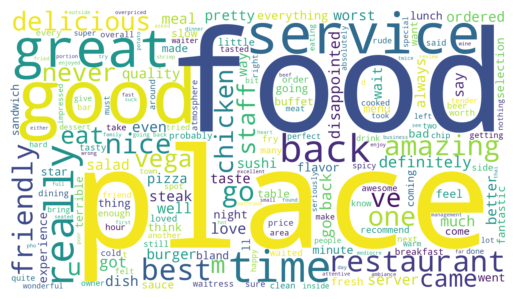

In [5]:
text = " ".join(review_line for review_line in data.train.text)
word_cloud = WordCloud(width = 1920, height = 1080,
                background_color ='white',
                stopwords = set(STOPWORDS),
                min_font_size = 10).generate(text)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.savefig(f"analysis/{dataset_name}/word_cloud.jpg", dpi=500)
plt.show()

## Model Training

### SVM

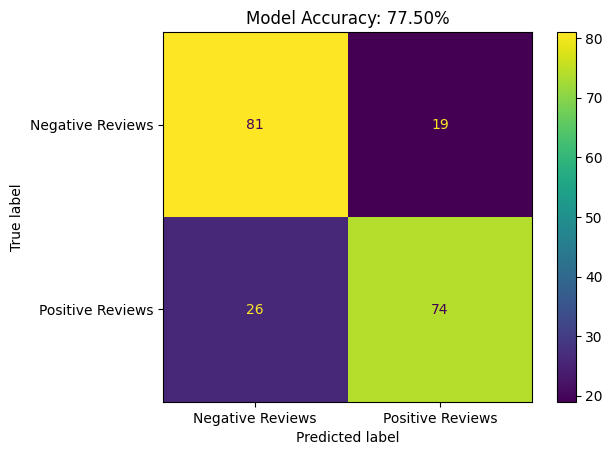

                  precision    recall  f1-score   support

Negative Reviews       0.76      0.81      0.78       100
Positive Reviews       0.80      0.74      0.77       100

        accuracy                           0.78       200
       macro avg       0.78      0.78      0.77       200
    weighted avg       0.78      0.78      0.77       200



In [13]:
model_name = "svm"
pipeline = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                      ('chi', SelectKBest(chi2, k=400)),
                     ('clf', LinearSVC(C=0.1, penalty='l2', max_iter=1000, dual=False))
                     ])
model = pipeline.fit(data.train["text"], data.train["label"])
predictions = model.predict(data.test["text"])
svm_accuracy = np.mean(predictions == data.test['label'])*100
cm = confusion_matrix(data.test["label"], predictions,)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative Reviews", "Positive Reviews"]).plot()
plt.title(f"Model Accuracy: {svm_accuracy:.2f}%")
if not os.path.exists(f"analysis/{dataset_name}"): os.makedirs(f"analysis/{dataset_name}")
plt.savefig(f"analysis/{dataset_name}/{model_name}_confusion_matrix.jpg", dpi=500)
plt.axis("off")
plt.show()
print(classification_report(data.test["label"], predictions, target_names=["Negative Reviews", "Positive Reviews"]))

### Naive Bayes

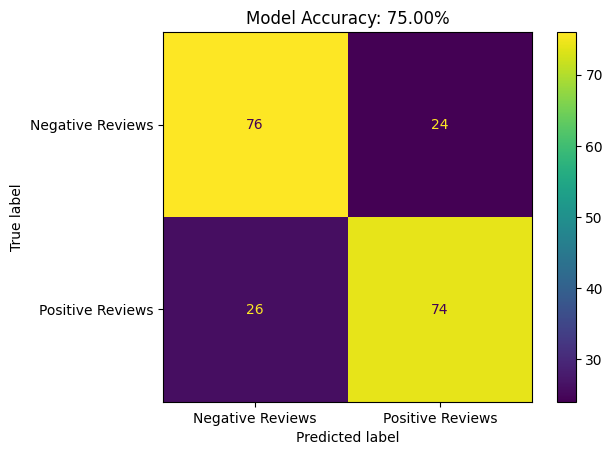

                  precision    recall  f1-score   support

Negative Reviews       0.75      0.76      0.75       100
Positive Reviews       0.76      0.74      0.75       100

        accuracy                           0.75       200
       macro avg       0.75      0.75      0.75       200
    weighted avg       0.75      0.75      0.75       200



In [12]:
model_name = "naive_bayes"
pipeline = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('chi', SelectKBest(chi2, k=400)),
                     ('clf', MultinomialNB())
                     ])
model = pipeline.fit(data.train["text"], data.train["label"])
predictions = model.predict(data.test["text"])
svm_accuracy = np.mean(predictions == data.test['label'])*100
cm = confusion_matrix(data.test["label"], predictions,)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative Reviews", "Positive Reviews"]).plot()
plt.title(f"Model Accuracy: {svm_accuracy:.2f}%")
if not os.path.exists(f"analysis/{dataset_name}"): os.makedirs(f"analysis/{dataset_name}")
plt.savefig(f"analysis/{dataset_name}/{model_name}_confusion_matrix.jpg", dpi=500)
plt.axis("off")
plt.show()
print(classification_report(data.test["label"], predictions, target_names=["Negative Reviews", "Positive Reviews"]))

### RandomForest

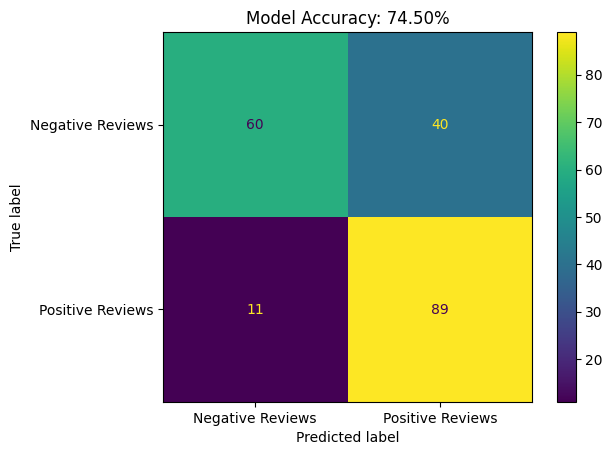

                  precision    recall  f1-score   support

Negative Reviews       0.85      0.60      0.70       100
Positive Reviews       0.69      0.89      0.78       100

        accuracy                           0.74       200
       macro avg       0.77      0.74      0.74       200
    weighted avg       0.77      0.74      0.74       200



In [11]:
model_name = "random_forest"
pipeline = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('chi', SelectKBest(chi2, k=400)),
                     ('clf', RandomForestClassifier())
                     ])
                     
model = pipeline.fit(data.train["text"], data.train["label"])
predictions = model.predict(data.test["text"])
svm_accuracy = np.mean(predictions == data.test['label'])*100
cm = confusion_matrix(data.test["label"], predictions,)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative Reviews", "Positive Reviews"]).plot()
plt.title(f"Model Accuracy: {svm_accuracy:.2f}%")
if not os.path.exists(f"analysis/{dataset_name}"): os.makedirs(f"analysis/{dataset_name}")
plt.savefig(f"analysis/{dataset_name}/{model_name}_confusion_matrix.jpg", dpi=500)
plt.axis("off")
plt.show()
print(classification_report(data.test["label"], predictions, target_names=["Negative Reviews", "Positive Reviews"]))